## AutoEncoder

AutoEncoders er TODO

<img src="../res/autoencoder.png" height="300px">

In [3]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Pipeline of processing operations
image_processing = transforms.Compose([
    transforms.ToTensor(), # Cast into torch.Tensor
    transforms.Normalize((0.5,), (0.5,)) # Pixel-values will range in [-1, 1]
])

train_dataset = MNIST(root='../data', train=True, transform=image_processing, download=True)
test_dataset = MNIST(root='../data', train=False, transform=image_processing, download=True) # Test data for later
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32) # Iterable that provides 16 data samples each iteration

En AutoEncoder består av to komponenter:
- Encoder
    - En sekvens med lineære lag som reduserer dimensjonaliteten.
    - Ender opp med en vektor med veldig få dimensjoner kontra 784 fra rådata.
- Decoder
    - En sekvens med lineære lag som rekonstruerer inputten fra den korte vektoren.

Vi tar i bruk `nn.Sequential` for å lage sekvenser av lag som dataen flyter gjennom.

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=200),
            nn.Tanh(),
            nn.Linear(in_features=200, out_features=42),
            nn.Tanh(),
            nn.Linear(in_features=42, out_features=16),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
             nn.Linear(in_features=16, out_features=42),
             nn.Tanh(),
             nn.Linear(in_features=42, out_features=200),
             nn.Tanh(),
             nn.Linear(200, 28*28),
             nn.Tanh()
        )

    def encode(self, data):
        out = torch.flatten(data, start_dim=1, end_dim=-1)
        out = self.encoder(out)
        return out
    
    def decode(self, data):
        out = self.decoder(data)
        return out.reshape(-1, 1, 28, 28)

    def forward(self, data):
        out = self.encode(data)
        out = self.decode(out)
        return out
    
autoencoder = AutoEncoder()
autoencoder.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=42, bias=True)
    (3): Tanh()
    (4): Linear(in_features=42, out_features=16, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=42, bias=True)
    (1): Tanh()
    (2): Linear(in_features=42, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [26]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 3

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as pbar:
        pbar.set_description(f"Epoch {epoch}")
        for i, (data, _) in enumerate(pbar): # no need for labels
            data = data.to(device)
            pred = autoencoder.forward(data) # Query model for predictions
            loss = loss_fn(pred, data)
            
            loss.backward() # Propagate the computational graph and calculate gradients
            optimizer.step() # Uses the calculated gradients on the registered parameters to perform an update
            optimizer.zero_grad() # Remove the gradients

            pbar.set_postfix(loss=loss.cpu().item()) if i%40 == 0 else None

Epoch 2: 100%|██████████| 1875/1875 [00:07<00:00, 253.47batch/s, loss=0.071] 


Vi studerer nå hvordan modellen klarer å rekonstruere et siffer fra datasettet.

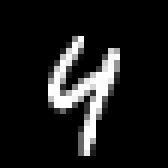

In [27]:
import sys
sys.path.append("../")

from utils.visualize import visualize


rand_index = torch.randint(0, len(train_dataset), (1,)).item()
data_sample, label_sample = train_dataset[rand_index]

visualize(data_sample)

In [28]:
encoding = autoencoder.encode(data_sample[None, ...].to(device)) # Add batch dimension
encoding
print(encoding.shape)
print(encoding)
visualize(encoding[None, ...])

torch.Size([1, 16])
tensor([[-0.7283, -0.6815, -0.1664, -0.6456, -0.4464,  0.3966, -0.6303, -0.1945,
          0.2879,  0.5607, -0.4341, -0.2634, -0.8297,  0.4171,  0.2058, -0.0583]],
       device='cuda:0', grad_fn=<TanhBackward0>)


In [29]:
encoding

tensor([[-0.7283, -0.6815, -0.1664, -0.6456, -0.4464,  0.3966, -0.6303, -0.1945,
          0.2879,  0.5607, -0.4341, -0.2634, -0.8297,  0.4171,  0.2058, -0.0583]],
       device='cuda:0', grad_fn=<TanhBackward0>)

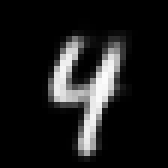

In [30]:
decoding = autoencoder.decode(encoding)
visualize(decoding.squeeze(0))

Ved å ha en flaskehals i midten av nettverket, har modellen lært seg en lav-dimensjonell representasjon av sifrene.

Det morsomme er at decoder-delen av nettverket kan anvendes som en generativ modell. Inputtet vil være en vektor av lav dimensjon. Vi har også brukt `Tanh` som aktiveringsfunksjon på output fra encoderen, som betyr at decoderen alltid vil forvente tall som ligger i $\langle-1, 1\rangle$. 

Hvis vi generer en 16-dimensjonal vektor med tilfeldige tall, og bruker dette som input til decoderen, får vi et _syntetisk_ siffer som output. Den 16-dimensjonale vektoren vil i faglitteraturen kalles for en _latent_ representasjon av et siffer.

Jeg skrev [masteroppgaven min](https://willdalh.github.io/thesis/thesis.pdf) om latente representasjoner i diffusjonsmodeller. Bare ta en titt 😄

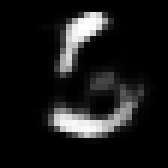

In [58]:
latent = (torch.rand(size=(1, 16))-0.5)*2
decoding = autoencoder.decode(latent.to(device))
visualize(decoding.squeeze(0))

Resultatene gjenspeiler den enkle arkitekturen som er valgt. Det er flere forbedringer man kan gjøre på arkitekturen for å få mer lovende sifre. 

# TODO FIX Architecture

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=32*7*7, out_features=512),
            nn.Tanh(),
            nn.Linear(in_features=512, out_features=42),
            nn.Linear(in_features=42, out_features=16),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=16, out_features=42),
            nn.Tanh(),
            nn.Linear(in_features=42, out_features=512),
            nn.Tanh(),
            nn.Linear(in_features=512, out_features=32*7*7),
            nn.Tanh(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def encode(self, data):
        # out = torch.flatten(data, start_dim=1, end_dim=-1)
        out = self.encoder(data)
        return out
    
    def decode(self, data):
        out = self.decoder(data)
        return out.reshape(-1, 1, 28, 28)

    def forward(self, data):
        out = self.encode(data)
        out = self.decode(out)
        return out
    
autoencoder = AutoEncoder()
autoencoder.to(device)